In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip install tensorboardcolab

  Running setup.py bdist_wheel for tensorboardcolab ... - done
  Stored in directory: /root/.cache/pip/wheels/ab/74/02/cda602d1dc28b2f12eab313c49b9bfa14d6371326bc2590e06
Successfully built tensorboardcolab


Wait for 8 seconds...
TensorBoard link:
https://b2caf602.ngrok.io
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 16, 16, 48)        1344      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 48)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 48)          192       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 96)          41568     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 96)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 3, 3, 96)          384       
_________________________________________________________________
conv2d_8 (

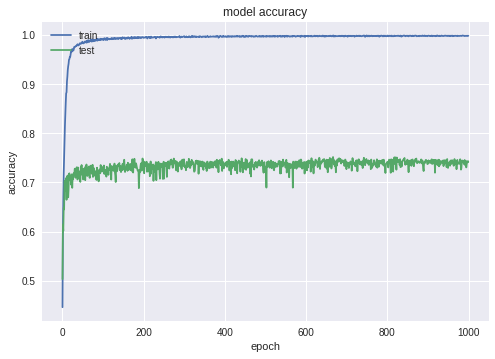

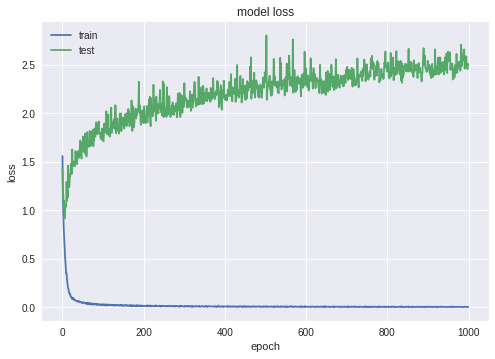

10000/10000 [==============================] - 2s 207us/step
Test loss: 2.295705946224928
Test accuracy: 0.7519
10000/10000 [==============================] - 2s 193us/step


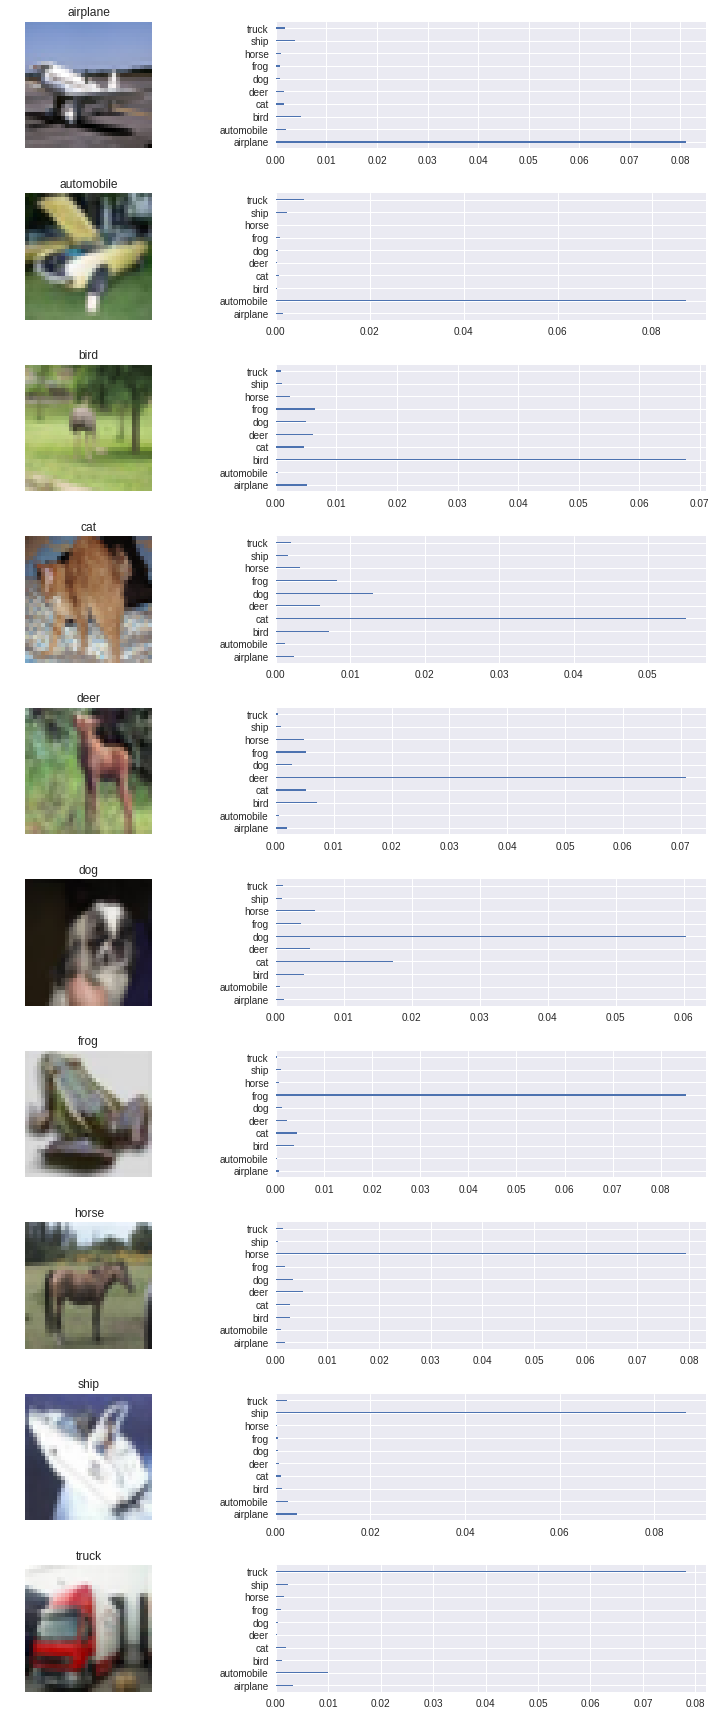

In [4]:
import keras
import pickle
import os.path
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LambdaCallback
from keras.callbacks import TensorBoard
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from sklearn.preprocessing import LabelBinarizer

# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 1000
epoch_file="gdrive/My Drive/colab/hw8_1_epoch_num.txt"
data_file="gdrive/My Drive/colab/hw8_1_data.txt"
filepath="gdrive/My Drive/colab/hw8_1_weights.best.hdf5"
tbc=TensorBoardColab()

# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# AlexNet Define the Model
model = Sequential()
# model.add(Conv2D(96, (11,11), strides=(4,4), activation='relu', padding='same', input_shape=(img_height, img_width, channel,)))
# for original Alexnet
model.add(Conv2D(48, (3,3), strides=(2,2), activation='relu', padding='same', input_shape=(img_height, img_width, channel,)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
# Local Response normalization for Original Alexnet
model.add(BatchNormalization())

model.add(Conv2D(96, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
# Local Response normalization for Original Alexnet
model.add(BatchNormalization())

model.add(Conv2D(192, (3,3), activation='relu', padding='same'))
model.add(Conv2D(192, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
# Local Response normalization for Original Alexnet
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


# print the model summary
model.summary()

report_data = {
    "acc":[],
    "val_acc":[],
    "loss":[],
    "val_loss":[]
}

num_epoch = 0
if not os.path.isfile(epoch_file):
  with open(epoch_file, "w+") as file:  
    file.write(str(num_epoch))
else:
  with open(epoch_file, "r") as file:  
    num_epoch = int(file.read())

if os.path.isfile(filepath):
  model.load_weights(filepath)

if os.path.isfile(data_file):
  with open(data_file, "rb") as file:
    report_data = pickle.load(file)

# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])


def updateEpoch(epoch, logs):
  to_save = num_epoch + epoch + 1
  report_data['acc'].append(logs['acc'])
  report_data['loss'].append(logs['loss'])
  report_data['val_acc'].append(logs['val_acc'])
  report_data['val_loss'].append(logs['val_loss'])
  with open(epoch_file, "w") as file:  
    file.write(str(to_save))
  with open(data_file, "wb") as file:
    pickle.dump(report_data, file)
  print(epoch, logs)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
lambdaCall = LambdaCallback(on_epoch_end=updateEpoch)
callbacks_list = [checkpoint,lambdaCall,TensorBoardColabCallback(tbc)]

# Train the Model

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=(epochs - num_epoch),
                    verbose=1,
                    callbacks=callbacks_list,
                    validation_data=(x_test, y_test))


# summarize history for accuracy
plt.plot(report_data['acc'])
plt.plot(report_data['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(report_data['loss'])
plt.plot(report_data['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Test the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
predictions = model.predict(x_test, verbose=1)

def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axs = plt.subplots(10, 2, figsize=(12,24))
    margin = 0.05
    ind = np.arange(n_classes)
    width = (1. - 2. * margin) / n_classes    
    arr_features = [None]*10
    arr_predictions = np.zeros((10, 10))
    last_image_i = 0
    
    for i, prediction in enumerate(predictions):
        label_id = label_ids[i]
        feature = features[i]
        arr_features[label_id] = feature
        max_id = np.argmax(prediction)
        arr_predictions[label_id][max_id] += 1
        last_image_i = i

    arr_predictions /= last_image_i
    
    for i in range(10):
      feature = arr_features[i]
      pred_name = label_names[i]
      prediction = arr_predictions[i]
      axs[i][0].imshow(feature)
      axs[i][0].set_title(pred_name)
      axs[i][0].set_axis_off()

      axs[i][1].barh(ind + margin, prediction, width)
      axs[i][1].set_yticks(ind + margin)
      axs[i][1].set_yticklabels(label_names)

    plt.tight_layout()

display_image_predictions(x_test, y_test, predictions)